## Libraries

In [1]:
%%time

# --- Install offline packages ---
try:
    import ace_tools_open
except ModuleNotFoundError:
    print('Installing ace tools...')
    !pip install -q /kaggle/input/offline-packages/itables-2.3.0-py3-none-any.whl
    !pip install -q /kaggle/input/offline-packages/ace_tools_open-0.1.0-py3-none-any.whl

try:
    import timm
except ModuleNotFoundError:
    print('Installing timm...')
    !pip install -q /kaggle/input/offline-packages/timm-1.0.15-py3-none-any.whl
    
try:
    import warmup_scheduler
except ModuleNotFoundError:
    print('Installing warmup-scheduler...')
    !pip install -q /kaggle/input/offline-packages/warmup_scheduler-0.3.tar.gz

# --- Core libraries ---
import os
import math
import random
import time
import numpy as np

# --- Data handling ---
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from dataclasses import dataclass, field
from sklearn.preprocessing import label_binarize

# --- PyTorch ---
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchaudio.functional import bandpass_biquad
from warmup_scheduler import GradualWarmupScheduler
from transformers import AutoFeatureExtractor, AutoModelForAudioClassification

# --- Audio processing ---
import torchaudio
import torchaudio.transforms as T

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio, display
from tqdm.notebook import tqdm
import ace_tools_open as tools
import torchvision
from torchvision.ops.focal_loss import sigmoid_focal_loss
import cv2

# --- Parallel and Custom Tools ---
from joblib import Parallel, delayed
from torch.amp import GradScaler, autocast
from concurrent.futures import ProcessPoolExecutor, as_completed
from typing import Optional, List, Tuple
import timm
import tempfile
import gc
import itertools
from glob import glob

Installing ace tools...
Installing warmup-scheduler...
  Preparing metadata (setup.py) ... done
CPU times: user 9.56 s, sys: 2.13 s, total: 11.7 s
Wall time: 29.3 s


In [2]:
dirc = "/kaggle/input/precomputing-spectrograms/precomputed_spectrograms"
b = [f for a in os.listdir(dirc) for f in os.listdir(os.path.join(dirc, a)) ]

dirc = "/kaggle/input/precomputing-spectrograms2/precomputed_spectrograms"
c = [f for a in os.listdir(dirc) for f in os.listdir(os.path.join(dirc, a)) ]

dirc = "/kaggle/input/precomputing-spectrograms3/precomputed_spectrograms"
d = [f for a in os.listdir(dirc) for f in os.listdir(os.path.join(dirc, a)) ]
print(len(d), len(b), len(c))

56168 56167 43239


## Configuration Parameters

In [3]:
@dataclass
class CFG:
    # General
    LOAD_DATA: bool = True
    seed: int = 69
    debug: bool = False
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    ## Data paths ##
    OUTPUT_DIR: str = '/kaggle/working/'
    temporary_dir: str = field(init=False)
    pre_processing_dir: str = "/kaggle/input/precomputing-spectrograms3" #"/kaggle/input/precomputing-spectrograms" #"/kaggle/working/eda-birdclef2025"
    spectrogram_dir: str = field(init=False)
    spectrogram_csv_filename: str = "spec_metadata.csv"
    spectrograms_metadata_path: str = field(init=False) # "filename", "num_frames", "primary_label"
    
    # Base path to dataset
    data_path: str = '/kaggle/input/birdclef-2025/'
    # Key file paths
    metadata_path: str = field(init=False)
    taxonomy_path: str = field(init=False)
    sample_submission_path: str = field(init=False)
    location_path: str = field(init=False)
    # Audio data directories
    train_data_path: str = field(init=False)
    test_soundscapes_path: str = field(init=False)
    unlabeled_soundscapes_path: str = field(init=False)

    # Audio config
    topDB: int = 80
    FS: int = 32000
    CHUNK_LENGTH: float = 5.0   # seconds
    N_FFT: int = 1024
    HOP_LENGTH: int = 512
    N_MELS: int = 128
    FMIN: int = 50
    FMAX: int = 16000
    POWER: int = 2
    SPEC_DTYPE: str = 'float16'  # for disk saving
    spectogram_time_frames: int = field(init=False)
    
    # VAD and Filtering
    VAD_ENABLED: bool = False  # Whether to apply Voice Activity Detection
    VAD_THRESHOLD: float = 0.4  # Confidence threshold for Silero VAD
    BANDPASS_LOW: int = 300
    BANDPASS_HIGH: int = 16000
    VISUALIZE_SKIPPED: bool = False  # Set to True to see spectrograms of skipped chunks


    # Training
    BATCH_SIZE: int = 32
    EPOCHS: int = 20
    criterion: str = 'BCEWithLogitsLoss'
    optimizer: str = 'AdamW'
    LEARNING_RATE: float = 1e-3
    weight_decay: float = 1e-5
    scheduler: str = 'CosineAnnealingLR'
    min_lr: float = 1e-6
    n_fold: int = 5
    num_workers: int = 4

    # Augmentation
    augment = True
    mixup = True
    aug_prob: float = 0.5
    mixup_alpha: float = 0.4

    # Model
    model_name: str = "efficientnet_b0" # 'efficientnet_b3_pruned', 'efficientnetv2_rw_m', 'efficientvit_l1', 'efficientvit_l2', 'efficientvit_m0'
    pretrained: bool = True
    in_channels: int = 1
    input_directory: str = '/kaggle/input/offline-packages'
    input_model_filename: str = field(init=False)
    output_model_filename: str = field(init=False)
    model_weights: str = field(init=False)
    num_classes: str = field(init=False)
    pretrained_pann_path: str = "/kaggle/input/pann-cnn14/Cnn14_mAP0.431.pth"

    # Focal Loss parameters
    alpha: float = 0.25 
    gamma: float = 2.0 
    reduction: str = "mean"
    bce_weight: float = 1.0
    focal_weight: float = 1.0
    secondary_weight: float = .5

    def __post_init__(self):
        self.metadata_path = os.path.join(self.data_path, 'train.csv')
        self.taxonomy_path = os.path.join(self.data_path, 'taxonomy.csv')
        self.sample_submission_path = os.path.join(self.data_path, 'sample_submission.csv')
        self.location_path = os.path.join(self.data_path, 'recording_location.txt')
        self.train_data_path = os.path.join(self.data_path, 'train_audio')
        self.test_soundscapes_path = os.path.join(self.data_path, 'test_soundscapes')
        self.unlabeled_soundscapes_path = os.path.join(self.data_path, 'train_soundscapes')
        self.spectrograms_metadata_path = os.path.join(self.pre_processing_dir, self.spectrogram_csv_filename)
        self.spectrogram_dir = os.path.join(self.pre_processing_dir, "precomputed_spectrograms")
        
        self.input_model_filename = f'{self.model_name}_pretrained.pth'
        self.output_model_filename = f'{self.model_name}_sed.pth'
        self.model_weights = os.path.join(self.input_directory, self.input_model_filename)
        self.num_classes = len(pd.read_csv(self.taxonomy_path))

        self.temporary_dir = tempfile.TemporaryDirectory().name
        self.spectogram_time_frames = int((self.FS * self.CHUNK_LENGTH) // self.HOP_LENGTH + 1)
        if self.debug:
            self.EPOCHS = 2
            print("⚠️ Debug mode is ON. Training only for 2 epochs.")

cfg = CFG()

In [4]:
def set_seed(seed=69):
    """
    Set seed for reproducibility
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed(cfg.seed)
print(f"Training with device: {cfg.device}")

Training with device: cuda


## Pre-processing

In [5]:
# Global variable for the VAD model (accessible in each worker)
global_vad_model = None
global_get_speech_timestamps = None

def initialize_vad_model():
    """
    Initializes the VAD model and assigns it to the global scope.
    This runs once per process.
    """
    global global_vad_model, global_get_speech_timestamps
    torch.set_num_threads(1)  # Avoid PyTorch oversubscription

    # Load the model
    global_vad_model, (global_get_speech_timestamps, _, _, _, _) = torch.hub.load(
        repo_or_dir='snakers4/silero-vad', 
        model='silero_vad',
        trust_repo=True
    )
    print("[INFO] Silero VAD model loaded successfully in worker process.")

class SpectrogramPreprocessor:
    """
    Converts audio files into log-mel spectrograms and saves them as .npy files.
    
    Supports:
    - Silero VAD for speech detection (via torch.hub)
    - 5-second chunking
    - Band-pass filtering
    - Parallel processing

    Methods:
    --------
    preprocess_file(filename) → Optional[List[Tuple[str, int]]]
        Process, chunk, and save spectrograms from a single audio file.
    preprocess_all_files(file_list) → List[Tuple[str, int]]
        Preprocess all files in parallel.
    """

    def __init__(self, cfg, num_workers = None):
        self.cfg = cfg
        self.sample_rate = cfg.FS
        self.chunk_samples = int(cfg.CHUNK_LENGTH * cfg.FS)
        os.makedirs(cfg.temporary_dir, exist_ok=True)

        # Torchaudio transforms
        self.mel_transform = T.MelSpectrogram(
            sample_rate=cfg.FS,
            n_fft=cfg.N_FFT,
            hop_length=cfg.HOP_LENGTH,
            n_mels=cfg.N_MELS,
            f_min=cfg.FMIN,
            f_max=cfg.FMAX,
            power=cfg.POWER
        )
        self.db_transform = T.AmplitudeToDB(top_db=cfg.topDB)

        num_workers = num_workers if num_workers is not None else cfg.num_workers
        if cfg.VAD_ENABLED and num_workers == 1:
            initialize_vad_model()

    def preprocess_file(self, filename: str, train_dir: str = cfg.train_data_path) -> Optional[List[Tuple[str, int]]]:
        """
        Preprocess an audio file into multiple 5-second log-mel spectrograms.
        
        Parameters:
        -----------
        filename : str
            Path to the audio file relative to the training directory.

        Returns:
        --------
        list of tuples or None:
            [(chunk_filename, num_frames), ...] if successful, else None.
        """
        file_path = os.path.join(train_dir, filename)
        if self.cfg.debug:
            print(filename)
        try:
            waveform = self._load_and_prepare_waveform(file_path)
            chunks = self._split_into_chunks(waveform)
            processed = []
            for idx, chunk in enumerate(chunks):
                
                # Apply VAD only if enabled
                if self.cfg.VAD_ENABLED:
                    is_XC = self._is_collection_xc(filename) 
                    if self._contains_human_voice(chunk, is_XC = is_XC):
                        if self.cfg.VISUALIZE_SKIPPED:
                            self._visualize_spectrogram(chunk, title=f"Skipped Chunk ending in {idx}")
                        continue  # Skip chunks with human voice
                    
                spec = self._waveform_to_spec(chunk)
                chunk_filename = f"{filename[:-4]}_chunk_{idx}.npy"
                primary = str(filename[:-4].split('/')[0])
                self._save_spectrogram(spec, chunk_filename)

                # Store chunk filename, num frames, and source filename
                processed.append((chunk_filename, spec.shape[-1], primary))

            return processed if processed else None
        except Exception as e:
            if self.cfg.debug:
                print(f"[ERROR] Failed to process {filename}: {e}")
            return None

    def _load_and_prepare_waveform(self, path: str) -> torch.Tensor:
        """
        Load audio, convert to mono, crop/pad to fixed length.

        Returns:
        --------
        waveform : Tensor [1, T]
        """
        waveform, sr = torchaudio.load(path)  # (channels, samples) = (2, 32000)
        if waveform.shape[0] > 1:
            # average the two channels and add a channel dimension back
            waveform = waveform.mean(dim=0, keepdim=True)  # convert to mono

        # Bandpass filter for noise removal
        #waveform = bandpass_biquad(waveform, self.sample_rate, self.cfg.BANDPASS_LOW, self.cfg.BANDPASS_HIGH)
        # Truncate to max allowed duration
        #max_samples = self.sample_rate * self.cfg.AUDIO_MAX_LEN
        #waveform = waveform[..., :max_samples]

        return waveform

    def _waveform_to_spec(self, waveform: torch.Tensor) -> torch.Tensor:
        """
        Convert waveform to normalized log-mel spectrogram.
        
        Returns:
        --------
        spec : Tensor [M, T]
        """
        mel = self.mel_transform(waveform)
        log_mel = self.db_transform(mel)
        norm_spec = (log_mel - log_mel.mean()) / (log_mel.std() + 1e-6)
        return norm_spec.squeeze(0)  # shape [M, T]

    def _split_into_chunks(self, waveform: torch.Tensor) -> List[torch.Tensor]:
        """
        Splits the waveform into 5-second chunks.
        
        Returns:
        --------
        list of Tensors:
            Each tensor represents 5 seconds of audio.
        """
        total_samples = waveform.shape[-1]
        chunks = []

        for start in range(0, total_samples, self.chunk_samples):
            end = start + self.chunk_samples
            chunk = waveform[..., start:end]
            
            # Apply logic for padding
            if self._should_pad_chunk(chunk, start, total_samples):
                pad_size = self.chunk_samples - chunk.shape[-1]
                chunk = F.pad(chunk, (0, pad_size))
                if self.cfg.debug:
                    print(f"[INFO] Padded chunk of {pad_size} to {self.chunk_samples} samples")
            elif chunk.shape[-1] < self.chunk_samples:
                if self.cfg.debug:
                    print(f"[INFO] Skipping under-sized chunk: {chunk.shape[-1]} samples")
                continue
            chunks.append(chunk)
        return chunks

    def _save_spectrogram(self, spec: torch.Tensor, filename: str):
        """
        Save the spectrogram as a .npy file.

        Parameters:
        -----------
        spec : torch.Tensor
            The normalized spectrogram tensor [M, T]
        filename : str
            Original filename, used to derive save path
        """
        save_path = os.path.join(cfg.temporary_dir, filename)
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        np.save(save_path, spec.numpy().astype(self.cfg.SPEC_DTYPE))

    def preprocess_all_files(self, file_list: List[str]) -> List[Tuple[str, int]]:
        """
        Runs preprocessing for all files in parallel.

        Parameters:
        -----------
        file_list : List[str]
            List of filenames to process.

        Returns:
        --------
        List of tuples (chunk_filename, num_frames).
        """
        print(f"[INFO] Starting parallel processing on {len(file_list)} files...")
        
        if self.cfg.VAD_ENABLED:
            results = self.run_in_parallel_with_VAD_enabled(file_list)
        results = self.run_in_parallel_no_VAD(file_list)
        
        print("[INFO] Pre-processing complete!")
        results_df = self._create_and_save_csv(results)
        return results_df

    def _create_and_save_csv(self, metadata):
        # Create a DataFrame from metadata
        spec_df = pd.DataFrame(metadata, columns=["filename", "num_frames", "primary_label"])
        
        # Display and save
        tools.display_dataframe_to_user(name="Spectrogram Metadata with Labels", dataframe=spec_df)
        spec_df.to_csv(os.path.join(cfg.OUTPUT_DIR, "spec_metadata.csv"), index=False)

    def run_in_parallel_with_VAD_enabled(self, file_list: List[str]) -> List[Tuple[str, int]]:
         # Use ProcessPoolExecutor with initializer
        results = []
        with ProcessPoolExecutor(max_workers=self.cfg.num_workers, initializer=initialize_vad_model) as executor:
            # Submit all tasks
            futures = {executor.submit(self.preprocess_file, f): f for f in tqdm(file_list, total=len(file_list), desc="Pre-computing spectograms")}
    
            # Collect results
            for future in tqdm(as_completed(futures), total=len(futures), desc="Collecting results"):
                #print("hi")
                try:
                    result = future.result()
                    if result is not None:
                        results.extend(result)
                except Exception as e:
                    print(f"[ERROR] Exception in worker process: {e}")
        return results

    def run_in_parallel_no_VAD(self, file_list: List[str]) -> List[Tuple[str, int]]:
        results = Parallel(n_jobs=self.cfg.num_workers)(
            delayed(self.preprocess_file)(f) for f in tqdm(file_list, desc="Pre-computing Spectrograms")
        )
        
        # Flatten the list of lists
        return [item for sublist in results if sublist is not None for item in sublist]

    def _contains_human_voice(self, chunk: torch.Tensor, is_XC=False) -> bool:
        """
        Detects if human voice is present in the chunk using Silero VAD.
        Uses the globally-initialized model in each worker.
        """
        if global_vad_model is None or global_get_speech_timestamps is None:
            raise ValueError("VAD Model not initialized in the worker process!")
        t = self.cfg.VAD_THRESHOLD if not is_XC else 0.7
        
        timestamps = global_get_speech_timestamps(chunk.numpy().flatten(), global_vad_model, return_seconds=True, threshold=t)
        return len(timestamps) > 0

    def _should_pad_chunk(self, chunk: torch.Tensor, start, total_samples: int) -> bool:
        """
        Determines if a chunk should be padded or discarded.
        """
        remaining_samples = total_samples - start
        return (total_samples < self.chunk_samples) or  ((self.chunk_samples // 2) < remaining_samples < self.chunk_samples)

    def _is_collection_xc(self, filename: str) -> bool:
        """
        Determine if VAD should be applied based on filename.
        - CSA, iNat: Always apply VAD.
        - XC: Apply VAD if the rating is 2 or lower.
        """
        if 'CSA' in filename or 'iNat' in filename:
            return False
        #if 'XC' in filename:
        return True

    def _visualize_spectrogram(self, chunk, title="Spectrogram"):
        """
        Visualizes a spectrogram of a skipped chunk.
        """
        spec = self._waveform_to_spec(chunk)
        plt.figure(figsize=(10, 4))
        
        plt.imshow(spec.numpy(), aspect='auto', origin='lower')
        plt.title(title)
        plt.colorbar()
        plt.show()


In [6]:
if cfg.LOAD_DATA:
    try:
        print("Loading pre-processed spectograms...")
    except:
        print("Error in loading pre-processed spectograms... computing them on the fly")
        cfg.LOAD_DATA = False
if not cfg.LOAD_DATA:
    # Initialize preprocessor
    preprocessor = SpectrogramPreprocessor(cfg)
    
    # Load training metadata
    train_df = pd.read_csv(cfg.metadata_path)
    
    # Get all filenames
    all_files = [f for f in list(train_df.filename) if f.endswith(".ogg")]
    
    # Start precomputation
    print("[INFO] Starting spectrogram pre-computation...")
    preprocessor.preprocess_all_files(all_files)

Loading pre-processed spectograms...


## Dataset, Dataloader and Augmentations

In [7]:
class PrecomputedSpectrogramDataset(Dataset):
    """
    PyTorch Dataset for loading precomputed log-mel spectrograms.

    Arguments:
    ----------
    metadata : pd.DataFrame
        DataFrame containing filenames, primary labels, and number of frames.
    spec_dir : str
        Directory where the spectrogram .npy files are saved.
    label_to_index : dict
        Mapping from class name to label index.
    augment : bool
        Whether to apply augmentation (placeholder for now).
    """
    def __init__(self, metadata, spec_dir, augment=False, three_channels=True):
        self.metadata = metadata
        self.spectrogram_dir = spec_dir
        self.label_to_class, self.label_to_index, _, self.filename_to_secondary_label = get_mappings()
        self.augment = augment
        self.three_channels = three_channels
        if self.augment:
            self.augmentor = SpectrogramAugmentor()

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        path = os.path.join(self.spectrogram_dir, row["filename"])
        
        # Load spectrogram
        spec = np.load(path, mmap_mode="r")
        spec = torch.tensor(spec, dtype=torch.float16).unsqueeze(0)  # [1, M, T]
        
        # Get the class name
        primary_label = row["primary_label"]
        class_name = self.label_to_class.get(primary_label, "Unknown")
        
        # Apply augmentations if enabled
        if self.augment and class_name in {"Aves", "Insecta", "Amphibia", "Mammalia"}:
            spec = self.augmentor.apply_augmentations(spec, class_name)
        
        # Convert to 3-channel image-like format
        if self.three_channels:
            spec = spec.repeat(3, 1, 1)
        
        # Multi-hot vector for primary labels
        primary_label_tensor = torch.zeros(len(self.label_to_index), dtype=torch.float16)
        if primary_label in self.label_to_index:
            primary_label_tensor[self.label_to_index[primary_label]] = 1.0
        
        # Multi-hot vector for secondary labels
        secondary_labels = self.filename_to_secondary_label.get(f"{row['filename'].split('_')[0]}.ogg", [])
        secondary_label_tensor = torch.zeros(len(self.label_to_index), dtype=torch.float16)
        for sec_label in secondary_labels:
            if sec_label in self.label_to_index:
                secondary_label_tensor[self.label_to_index[sec_label]] = 0.5
    
        # Combine them (primary gets 1.0 weight, secondary gets 0.5 weight)
        combined_labels = primary_label_tensor + secondary_label_tensor
        combined_labels = torch.clamp(combined_labels, 0, 1)  # Ensure it's only 0 or 1
        
        return {
            "spectrogram": spec, 
            "labels": combined_labels, 
            "filename": row["filename"], 
            "class_name": class_name
        }

def collate_fn(batch, mixup=False, alpha=0.4):
    """
    Custom collate function to handle varying-size spectrograms and apply Mixup if specified.

    Parameters:
    -----------
    batch : list
        List of samples (dict) with spectrogram, label, and filename.
    mixup : bool
        Whether to apply Mixup augmentation to the batch.
    alpha : float
        Alpha parameter for the Beta distribution in Mixup.

    Returns:
    --------
    dict : 
        Dictionary with stacked tensors and filenames.
    """
    if len(batch) == 0:
        return {"spectrograms": None, "labels": None, "filenames": None}
    
    # Extract elements
    specs = [item["spectrogram"] for item in batch]
    labels = [item["labels"] for item in batch]
    filenames = [item["filename"] for item in batch]

    # Stack along the batch dimension
    specs = torch.stack(specs)
    labels = torch.stack(labels)

    # 🚀 Apply Mixup if specified and more than one element exists in the batch
    if mixup and len(batch) > 1:
        indices = torch.randperm(len(batch))
        mixed_specs = []
        mixed_labels = []

        for i in range(0, len(batch) - 1, 2):
            lam = np.random.beta(alpha, alpha)
            spec1, spec2 = specs[i], specs[indices[i]]
            label1, label2 = labels[i], labels[indices[i]]

            mixed_spec = lam * spec1 + (1 - lam) * spec2
            mixed_label = lam * label1 + (1 - lam) * label2

            mixed_specs.append(mixed_spec)
            mixed_labels.append(mixed_label)

        # If the batch size is odd, we append the last sample as it is
        if len(batch) % 2 != 0:
            mixed_specs.append(specs[-1])
            mixed_labels.append(labels[-1])

        specs = torch.stack(mixed_specs)
        labels = torch.stack(mixed_labels)

    return {"spectrograms": specs, "labels": labels, "filenames": filenames}

def get_mappings():
    """
    Creates label-to-class and label-to-index mappings.
    Also maps filenames to their associated secondary labels.
    
    Returns:
    --------
    - label_to_class : dict
        Maps primary labels to their respective class names.
    - label_to_index : dict
        Maps primary labels to unique index values.
    - filename_to_secondary_label : dict
        Maps filenames to lists of secondary labels.
    """
    # Load the datasets
    taxonomy_df = pd.read_csv(cfg.taxonomy_path)
    metadata_df = pd.read_csv(cfg.spectrograms_metadata_path)
    train_df = pd.read_csv(cfg.metadata_path)
    
    # Filter out unused labels
    used_labels = set(metadata_df["primary_label"].unique())
    taxonomy_df = taxonomy_df[taxonomy_df['primary_label'].isin(used_labels)]

    # Label to Class Mapping
    label_to_class = taxonomy_df.set_index('primary_label')['class_name'].to_dict()

    # Label to Index Mapping → Now guaranteed to match!
    label_to_index = {label: idx for idx, label in enumerate(sorted(label_to_class.keys()))}
    index_to_label = {idx: label for idx, label in enumerate(sorted(label_to_class.keys()))}

    # 🌟 New Logic to retrieve filename → secondary_labels
    filename_to_secondary_label = {}

    # Iterate over the DataFrame
    for _, row in train_df.iterrows():
        filename = row["filename"]
        secondary_labels = eval(row["secondary_labels"]) if isinstance(row["secondary_labels"], str) and row["secondary_labels"] != "['']" else []

        # Only add if there are secondary labels
        if len(secondary_labels) > 0:
            filename_to_secondary_label[filename] = secondary_labels

    # Display the label maps only once (no need to repeat every call)
    if not hasattr(get_mappings, "_displayed"):
        tools.display_dataframe_to_user(name="Label to Class", dataframe=pd.DataFrame(label_to_class.items(), columns=["Animal Label", "Class Name"]))
        tools.display_dataframe_to_user(name="Label Map", dataframe=pd.DataFrame(label_to_index.items(), columns=["Animal Label", "Index"]))
        tools.display_dataframe_to_user(name="Filename to Secondary Labels", dataframe=pd.DataFrame(list(filename_to_secondary_label.items()), columns=["Filename", "Secondary Labels"]))
        get_mappings._displayed = True
    
    return label_to_class, label_to_index, index_to_label, filename_to_secondary_label


In [8]:
class SpectrogramAugmentor:
    def __init__(self, time_mask_prob=0.3, freq_mask_prob=0.3, random_erase_prob=0.5):
        self.time_mask_prob = time_mask_prob
        self.freq_mask_prob = freq_mask_prob
        self.random_erase_prob = random_erase_prob

    def time_mask(self, spec, num_masks=2, max_mask_size=20):
        """Apply Time Masking"""
        for _ in range(num_masks):
            t = random.randint(0, spec.size(2) - 1)
            mask_size = random.randint(5, max_mask_size)
            spec[:, :, t:t + mask_size] = 0
        return spec

    def freq_mask(self, spec, num_masks=2, max_mask_size=20):
        """Apply Frequency Masking"""
        for _ in range(num_masks):
            f = random.randint(0, spec.size(1) - 1)
            mask_size = random.randint(5, max_mask_size)
            spec[:, f:f + mask_size, :] = 0
        return spec

    def random_erasing(self, spec, max_rect=20):
        """Apply Random Erasing"""
        if random.random() < self.random_erase_prob:
            x = random.randint(0, spec.size(2) - max_rect)
            y = random.randint(0, spec.size(1) - max_rect)
            w = random.randint(5, max_rect)
            h = random.randint(5, max_rect)
            spec[:, y:y+h, x:x+w] = 0
        return spec

    def apply_augmentations(self, spec, class_name):
        """
        Conditional augmentations based on class name.
        """
        if class_name == "Aves":  # Birds
            if random.random() < self.time_mask_prob:
                spec = self.time_mask(spec)
            if random.random() < self.freq_mask_prob:
                spec = self.freq_mask(spec)

        elif class_name == "Insecta":  # Insects
            if random.random() < self.freq_mask_prob:
                spec = self.freq_mask(spec, max_mask_size=30)
            if random.random() < self.random_erase_prob:
                #spec = self.random_erasing(spec, max_rect=30)
                pass

        elif class_name == "Amphibia":  # Amphibians
            if random.random() < self.time_mask_prob:
                spec = self.time_mask(spec, max_mask_size=30)
            if random.random() < self.freq_mask_prob:
                spec = self.freq_mask(spec)

        elif class_name == "Mammalia":  # Mammals
            if random.random() < self.time_mask_prob:
                spec = self.time_mask(spec)
            if random.random() < self.freq_mask_prob:
                spec = self.freq_mask(spec)

        return spec


In [9]:
# Read metadata (precomputed filenames and labels)
metadata = pd.read_csv(cfg.spectrograms_metadata_path)

# Stratified train/val split
train_df_split, val_df_split = train_test_split(
    metadata,
    test_size=0.02,
    stratify=metadata["primary_label"],
    random_state=cfg.seed
)

# Create Dataset instances
train_dataset = PrecomputedSpectrogramDataset(train_df_split, cfg.spectrogram_dir, augment=True)
val_dataset = PrecomputedSpectrogramDataset(val_df_split, cfg.spectrogram_dir, augment=False)


# Show some stats to the user
split_stats = pd.DataFrame({
    "Set": ["Train", "Validation"],
    "Samples": [len(train_dataset), len(val_dataset)]
})
tools.display_dataframe_to_user(name="Train/Validation Split Stats", dataframe=split_stats)


Label to Class


Label Map


Filename to Secondary Labels


Train/Validation Split Stats


Sampled Spectrograms


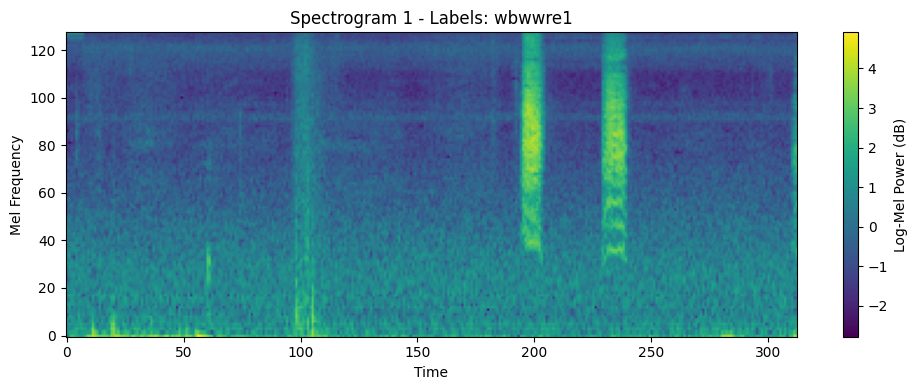

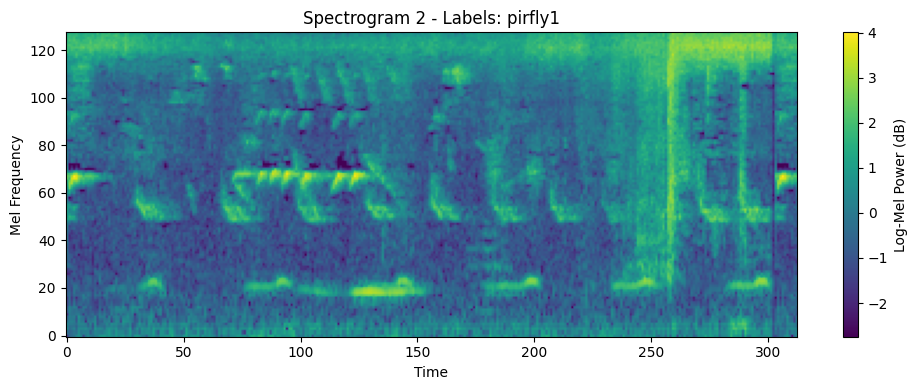

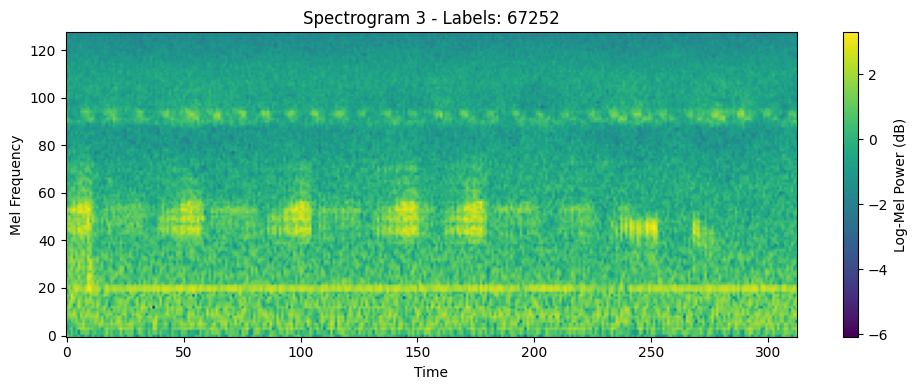

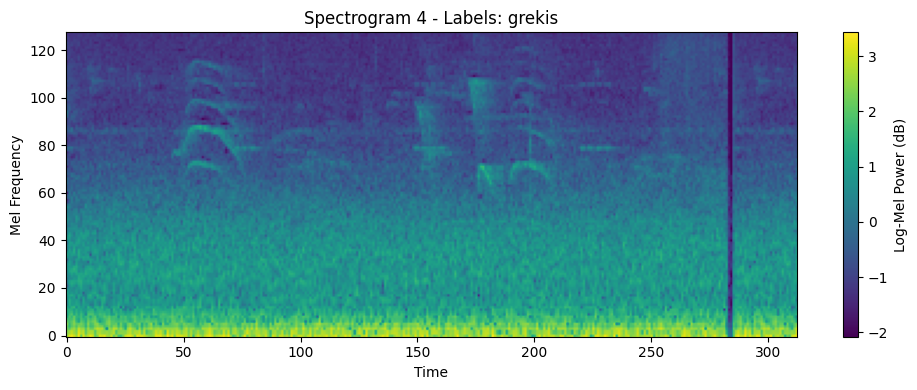

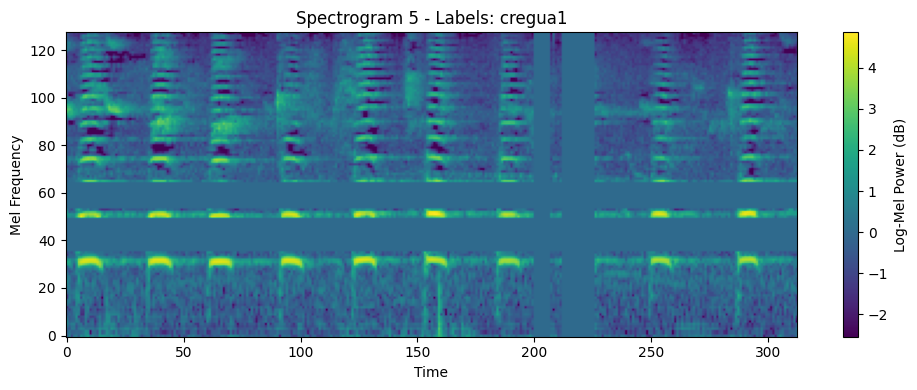

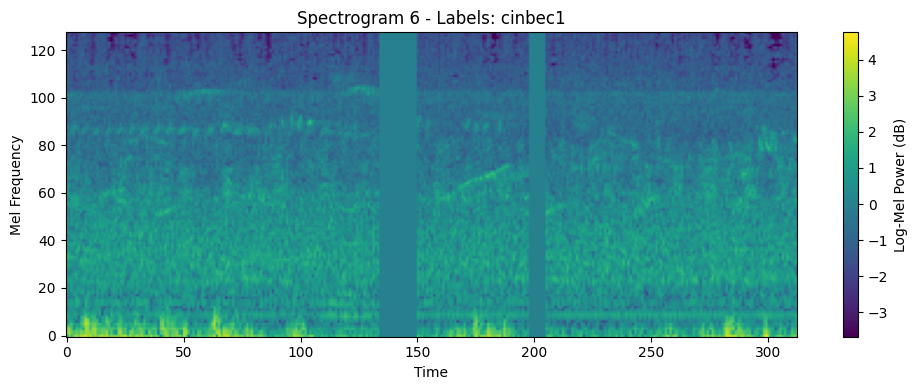

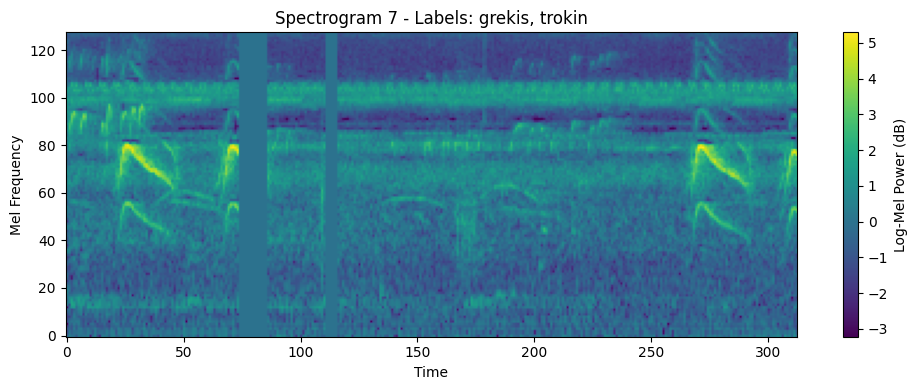

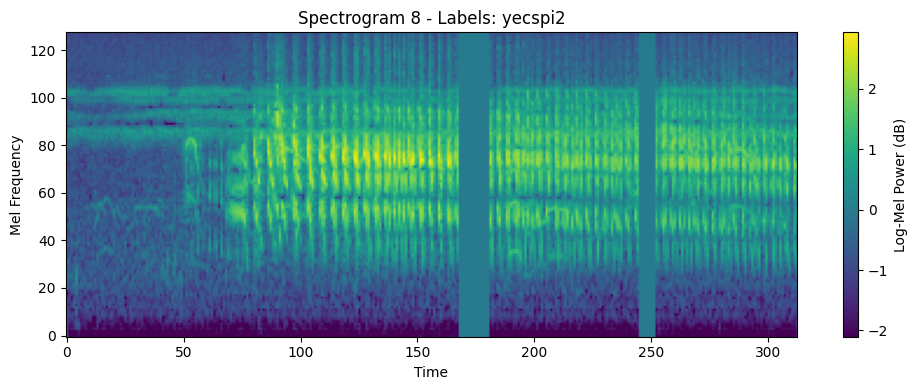

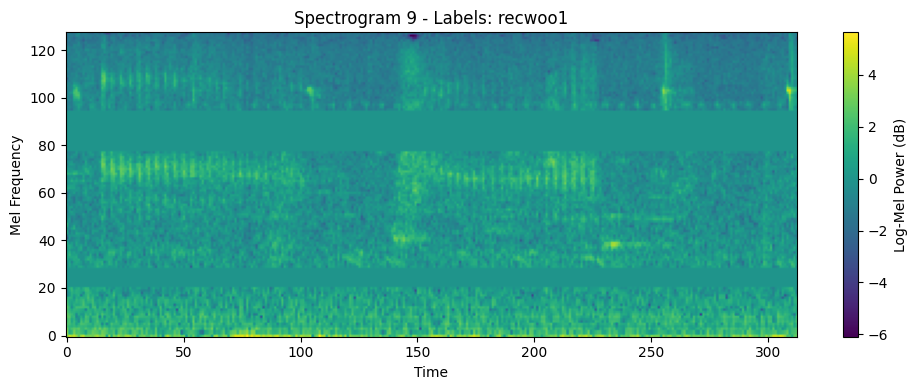

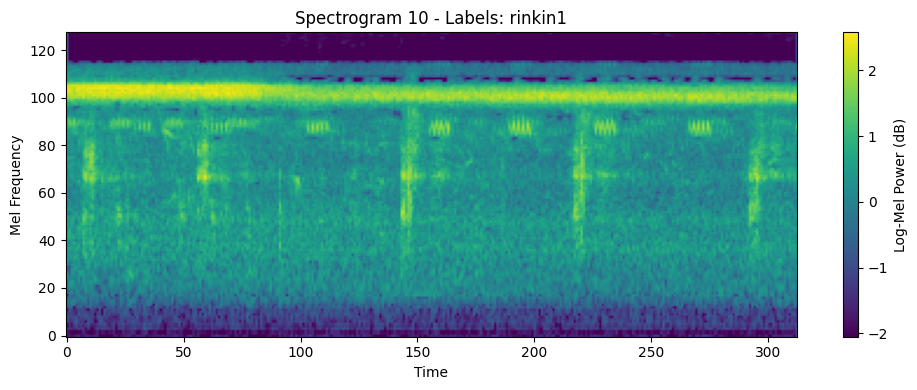

In [10]:
# Sample a few examples from the dataset
num_samples = 10
samples = random.sample(range(len(train_dataset)), num_samples)

# Collect data to visualize and inspect
spectrograms = []
labels = []
filenames = []

# Fetch the label mappings
_, _, index_to_label, _ = get_mappings()

for idx in samples:
    item = train_dataset[idx]
    spec = item["spectrogram"]  # shape [3, M, T]
    spectrograms.append(spec[0].numpy())  # just one channel for visualization
    
    # Get active class indices
    primary_label = (item["labels"] == 1).nonzero(as_tuple=True)[0].item()
    secondary_labels = (item["labels"] > 0).nonzero(as_tuple=True)[0]

    # Convert indices to class names
    primary_class_name = index_to_label[primary_label]
    secondary_class_names = [index_to_label[idx.item()] for idx in secondary_labels if idx!=primary_label]
    
    # Combine primary and secondary labels
    all_labels = [primary_class_name] + secondary_class_names
    labels.append(", ".join(all_labels))
    filenames.append(item["filename"])

# Display metadata table for the visualized samples
df_viz = pd.DataFrame({
    "Filename": filenames,
    "Labels": labels
})
tools.display_dataframe_to_user(name="Sampled Spectrograms", dataframe=df_viz)

# Plot spectrograms
for i in range(num_samples):
    plt.figure(figsize=(10, 4))
    plt.imshow(spectrograms[i], aspect='auto', origin='lower')
    plt.title(f"Spectrogram {i+1} - Labels: {labels[i]}")
    plt.xlabel("Time")
    plt.ylabel("Mel Frequency")
    plt.colorbar(label="Log-Mel Power (dB)")
    plt.tight_layout()
    plt.show()


Easy to see how time and frequency are masked in some samples.

In [11]:
def create_dataloader(dataset, cfg, shuffle, collate_fn, sampler = None):
    """
    Creates a DataLoader for a given dataset.

    Parameters:
    -----------
    dataset : Dataset
        PyTorch dataset object.
    cfg : object
        Configuration object containing batch size and num_workers.
    shuffle : bool
        Whether to shuffle the dataset.
    collate_fn : callable
        Collate function for batching.

    Returns:
    --------
    DataLoader:
        A PyTorch DataLoader instance.
    """
    if sampler is not None:
        shuffle = False
        
    loader = DataLoader(
        dataset,
        batch_size=cfg.BATCH_SIZE,
        shuffle=shuffle,
        num_workers=cfg.num_workers,
        pin_memory=True,
        collate_fn=collate_fn,
        sampler=sampler
    )
    return loader

def get_balanced_sampler(df, label_col, max_factor=10.0):
    """
    Returns a WeightedRandomSampler where rare classes are upsampled,
    but not overly dominant (via capped weight scaling).
    
    Parameters:
    -----------
    df : pd.DataFrame
        Your metadata with a label column.
    label_col : str
        Column containing class labels.
    max_factor : float
        Cap the maximum ratio between largest and smallest weight.
    """
    class_counts = df[label_col].value_counts().to_dict()
    min_count = min(class_counts.values()) # 4
    
    weights = df[label_col].map(lambda x: min(max_factor, class_counts[x] / min_count))
    weights = 1.0 / weights
    return WeightedRandomSampler(weights.values, len(weights), replacement=True)

def get_log_balanced_sampler(df, label_col, base=np.e):
    """
    Returns a WeightedRandomSampler using inverse log-frequency balancing.

    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with labels.
    label_col : str
        Column with class labels.
    base : float
        Base of the logarithm (default: natural log).

    Returns:
    --------
    WeightedRandomSampler object.
    """
    # Step 1: Get counts
    class_counts = df[label_col].value_counts()
    
    # Step 2: Apply log to compress large values
    log_counts = np.log(class_counts + 1) / np.log(base)  # +1 to avoid log(0)
    
    # Step 3: Invert and normalize
    inv_log = 1.0 / log_counts
    inv_log /= inv_log.sum()

    # Step 4: Assign weights per sample
    weights = df[label_col].map(inv_log)
    
    return WeightedRandomSampler(weights.values, len(weights), replacement=True)


## Models

In [12]:
class EfficientNetClassifier(nn.Module):
    """
    Simple EfficientNet-based audio classifier (no SED / attention).

    This model:
    - Uses a pretrained EfficientNet backbone (e.g., b0–b3)
    - Replaces the classifier head with a custom one
    - Includes dropout and batch normalization
    - Outputs clip-level logits (or optionally, probabilities)

    Parameters:
    -----------
    cfg : object
        Configuration object with fields:
        - model_name: str (e.g., 'efficientnet_b0')
        - pretrained: bool
        - num_classes: int
        - model_weights: Optional[str]
        - device: str
    """
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.device = torch.device(cfg.device)

        # Load base model
        self.backbone = timm.create_model(cfg.model_name, pretrained=cfg.pretrained)

        # Load weights manually
        checkpoint_path = cfg.model_weights
        if checkpoint_path:
            print(f"[INFO] Loading weights from {checkpoint_path}")
            state_dict = torch.load(checkpoint_path, map_location=self.device, weights_only=True)
            if "model" in state_dict:
                state_dict = state_dict["model"]
            self.backbone.load_state_dict(state_dict, strict=False)

        # Replace classifier head
        in_features = self.backbone.classifier.in_features
        self.backbone.classifier = nn.Sequential(
            nn.BatchNorm1d(in_features),
            nn.Dropout(0.3),
            nn.Linear(in_features, cfg.num_classes),
            # nn.Sigmoid()  # Uncomment for multi-label classification
        )

    def forward(self, x):
        """
        Forward pass of the model.

        Parameters:
        -----------
        x : torch.Tensor
            Input tensor [B, 3, Freq, Time] (e.g., log-mel spectrogram)

        Returns:
        --------
        torch.Tensor:
            Logits (or probabilities if sigmoid enabled) [B, num_classes]
        """
        return self.backbone(x)


In [13]:
class EfficientNetFrequencySED(nn.Module):
    """
    EfficientNet with a custom SED head for frequency-wise attention.
    
    This model:
    - Uses a pretrained EfficientNet backbone
    - Applies a frequency-wise attention mechanism
    - Outputs class probabilities for multi-class classification
    
    Arguments:
    ----------
    cfg : object
        Configuration object (assumes it's an instance of CFG)
    """
    def __init__(self, cfg):
        super().__init__()
        
        # Store config and device
        self.cfg = cfg
        self.device = torch.device(cfg.device)

        # Create model with the correct architecture
        self.backbone = timm.create_model(cfg.model_name, pretrained=cfg.pretrained)

        # Remove classifier head, we will add our own
        self.feature_dim = self.backbone.classifier.in_features
        self.backbone.classifier = nn.Identity()  # Remove classifier

        # Frequency-wise attention block -> attention mechanism to emphasize important frequency regions.
        self.att_block = nn.Sequential(
            nn.AdaptiveAvgPool2d((None, 1)),          # Mean over frequency bands
            nn.Conv2d(self.feature_dim, self.feature_dim, kernel_size=1),
            nn.Sigmoid()
        )

        # Custom classifier head
        self.classifier = nn.Sequential(
            nn.Conv2d(self.feature_dim, cfg.num_classes, kernel_size=1),
            nn.AdaptiveMaxPool2d((1, 1)),
            nn.Flatten()
        )

    def forward(self, x):
        """
        Forward pass of the model.
        
        Parameters:
        -----------
        x : torch.Tensor
            Input tensor of shape [B, 3, M, T], where:
            - B = Batch size
            - M = Mel bands (frequency bins)
            - T = Time frames

        Returns:
        --------
        torch.Tensor:
            Output tensor of shape [B, num_classes]
        """
        x = x.to(self.device)
        features = self.backbone.forward_features(x)  # EfficientNet backbone [B, C, M', T']
        attn = self.att_block(features)  # Attention on frequency bands [B, C, T', 1]
        features = features * attn       # Apply attention
        
        out = self.classifier(features)  # Classify [B, num_classes]
        return out


def model_predict_fn(spec_tensor: torch.Tensor) -> torch.Tensor:
    """
    Runs inference on a single spectrogram and returns per-class probabilities.
    Expects input shape [1, 3, M, T].
    """
    model.eval()
    with torch.no_grad(), autocast(device_type=cfg.device):
        outputs = model(spec_tensor.to(cfg.device))
        probs = torch.sigmoid(outputs)
    return probs.squeeze(0).cpu()
    
# === Load your trained model ===
model = EfficientNetFrequencySED(cfg)


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

In [14]:
class EfficientNetTimeSED(nn.Module):
    """
    EfficientNet with a custom SED head for time-wise attention.
    
    This model:
    - Uses a pretrained EfficientNet backbone
    - Applies a frequency-wise attention mechanism
    - Outputs class probabilities for multi-class classification
    
    Arguments:
    ----------
    cfg : object
        Configuration object (an instance of CFG)
    """
    def __init__(self, cfg):
        super().__init__()
        
        # Store config and device
        self.cfg = cfg
        self.device = torch.device(cfg.device)

        # Create model with the correct architecture
        self.backbone = timm.create_model(cfg.model_name, pretrained=cfg.pretrained)

        # Load weights manually
        checkpoint_path = cfg.model_weights
        if checkpoint_path:
            print(f"[INFO] Loading weights from {checkpoint_path}")
            state_dict = torch.load(checkpoint_path, map_location=self.device, weights_only=True)
            if "model" in state_dict:
                state_dict = state_dict["model"]  # In case it's wrapped in 'model' key
            self.backbone.load_state_dict(state_dict)

        # Remove classifier head, we will add our own
        self.feature_dim = self.backbone.classifier.in_features
        self.backbone.classifier = nn.Identity()  # Remove classifier

        # Time-wise attention block -> attention mechanism to emphasize important time regions (when did the animal spoke?).
        self.att_block = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, None)),          # Averages across frequency, keeps time axis intact. → shape becomes [B, C, 1, T]
            nn.Conv2d(self.feature_dim, self.feature_dim, kernel_size=1), # → pointwise attention weighting
            nn.Sigmoid()   # → [0, 1] weights per time step
        )

        # Custom classifier head
        self.classifier = nn.Sequential(
            nn.Conv2d(self.feature_dim, cfg.num_classes, kernel_size=1),
            nn.AdaptiveMaxPool2d((1, 1)),
            nn.Flatten()
        )

    def forward(self, x):
        """
        Forward pass of the model.
        
        Parameters:
        -----------
        x : torch.Tensor
            Input tensor of shape [B, 3, M, T], where:
            - B = Batch size
            - M = Mel bands (frequency bins)
            - T = Time frames

        Returns:
        --------
        torch.Tensor:
            Output tensor of shape [B, num_classes]
        """
        features = self.backbone.forward_features(x)  # EfficientNet backbone feature map [B, C, F', T'] where F' is the compressed frequency axis and T' the time steps (how many chunks/segments of the input timeline)
        # print(features.shape)
        attn = self.att_block(features)  # Attention on time bands [B, C, 1, T']
        # print(attn.shape)
        features = features * attn       # Apply attention ( dims down irrelevant time steps and boosts relevant ones)
        
        out = self.classifier(features)  # Classify [B, num_classes]
        return out

model = EfficientNetTimeSED(cfg).to(cfg.device)

# Show model summary
sample_input = torch.randn(2, 3, cfg.N_MELS, cfg.spectogram_time_frames).to(cfg.device)  # [Batch, Channels, Mel Bands, Time Frames]
output = model(sample_input)
print(f"Model Output Shape: {output.shape}")  # Should be [2(B), num_classes]
# model

[INFO] Loading weights from /kaggle/input/offline-packages/efficientnet_b0_pretrained.pth
Model Output Shape: torch.Size([2, 206])


## Training utilities

In [15]:
class Trainer:
    """
    Trainer class to handle model training and evaluation.
    
    Parameters:
    -----------
    model : nn.Module
        The model to be trained.
    cfg : object
        Configuration object with training parameters.
    criterion : torch.nn.Module
        Loss function.
    optimizer : torch.optim.Optimizer
        Optimizer for model updates.
    scheduler : torch.optim.lr_scheduler
        Learning rate scheduler.
    """
    def __init__(self, model, cfg, criterion, optimizer, scheduler):
        self.model = model.to(cfg.device)
        self.cfg = cfg
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = cfg.device
        self.history = []
        self.scaler = GradScaler()  # ⚡️ Mixed Precision Support

    def train_one_epoch(self, loader):
        """
        Runs one full epoch of training with tqdm progress bar.
        """
        self.model.train()
        total_loss = 0.0
        all_targets = []
        all_outputs = []

        for batch in tqdm(loader, desc="Training Batch", leave=False):
            inputs = batch["spectrograms"].to(self.device)  # [16, 3, 128, 313]
            targets = batch["labels"].to(self.device)  # [16, 206]
                
            # Only keep primary labels for AUC calculation
            primary_only_targets = (targets == 1).int()  # Convert to float for AUC compatibility

            self.optimizer.zero_grad()
            with autocast(device_type=self.device):
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)

            # Scale the loss and backpropagate
            self.scaler.scale(loss).backward()
            self.scaler.step(self.optimizer)
            self.scaler.update()

            total_loss += loss.item() * inputs.size(0)

            # Collect for AUC calculation
            all_targets.append(primary_only_targets.cpu().numpy())
            all_outputs.append(torch.sigmoid(outputs).detach().cpu().numpy())

        # AUC Calculation
        y_true = np.concatenate(all_targets, axis=0) # (40559, 206)
        y_pred = np.concatenate(all_outputs, axis=0)

        #print(y_true.shape, y_true.dtype, y_pred.dtype)
        assert y_true.shape == y_pred.shape
        assert y_true.shape[1] == self.cfg.num_classes
        #assert y_true.dtype == np.int32
        #assert y_pred.dtype == np.float16
        #assert set(np.unique(y_true)).issubset({0, 1})
        
        auc_score = self.calculate_auc(y_true, y_pred)


        return total_loss / len(loader.dataset), auc_score

    def evaluate(self, loader):
        """
        Evaluates the model on the validation set with tqdm progress bar.
        """
        self.model.eval()
        all_targets = []
        all_outputs = []

        with torch.no_grad():
            for batch in tqdm(loader, desc="Evaluating Batch", leave=False):
                inputs = batch["spectrograms"].to(self.device)
                targets = batch["labels"].to(self.device).float()
                
                # Only keep primary labels for AUC calculation
                primary_only_targets = (targets == 1).int()  # Convert to float for AUC compatibility


                # Mixed precision inference
                with autocast(device_type=self.device):
                    outputs = self.model(inputs)
                    outputs = torch.sigmoid(outputs).detach().cpu().numpy()

                all_targets.append(primary_only_targets.cpu().numpy())
                all_outputs.append(outputs)

        y_true = np.concatenate(all_targets, axis=0) # (40559, 206)
        y_pred = np.concatenate(all_outputs, axis=0)

        # Calculate AUC
        auc_score = self.calculate_auc(y_true, y_pred)
        return auc_score
        
    def calculate_auc(self, y_true, y_pred):
        """
        Calculates the macro ROC-AUC score.
        
        Parameters:
        -----------
        y_true : np.ndarray
            Ground truth binary labels (multi-hot encoded).
        y_pred : np.ndarray
            Model predictions (probabilities).
        
        Returns:
        --------
        float:
            Macro ROC-AUC score.
        """
        
        scores = []
        for i in range(y_true.shape[1]):
            # 🔎 Only compute if there are both positive and negative samples
            if 0 < np.sum(y_true[:, i]) < len(y_true):
                try:
                    scores.append(roc_auc_score(y_true[:, i], y_pred[:, i], average="macro"))
                except ValueError as e:
                    print(f"[WARNING] ValueError during AUC calculation for class index: {i}")
                    print(e)
            else:
                #print(f"[INFO] Skipping class index {i} {' '*(2-i//10)} due to insufficient positive or negative samples.")
                pass
        
        if len(scores) == 0:
            print("[ERROR] No valid classes found for AUC calculation.")
            return 0.0
        
        return np.mean(scores)


    def fit(self, train_loader, val_loader=None):
        """
        Runs the full training loop with tqdm progress bar.
        """
        print(f"[INFO] Starting training... at {time.strftime('%H:%M:%S')}")
        for epoch in tqdm(range(self.cfg.EPOCHS), total=self.cfg.EPOCHS, desc="Training Epoch"):
            start_time = time.time()

            # Train and Evaluate
            train_loss, train_auc = self.train_one_epoch(train_loader)
            if val_loader is not None:
                val_auc = self.evaluate(val_loader)
                # Record history
                self.history.append((epoch + 1, train_loss, train_auc, val_auc))
                print(f"Epoch {epoch + 1}/{self.cfg.EPOCHS} - "
                      f"Loss: {train_loss:.4f} - "
                      f"Train AUC: {train_auc:.4f} - "
                      f"Val AUC: {val_auc:.4f} - "
                      f"Time: {time.time() - start_time:.1f}s")
            else:
                # Record history
                self.history.append((epoch + 1, train_loss, train_auc))
                print(f"Epoch {epoch + 1}/{self.cfg.EPOCHS} - "
                      f"Loss: {train_loss:.4f} - "
                      f"Train AUC: {train_auc:.4f} - "
                      f"Time: {time.time() - start_time:.1f}s")

            # Scheduler step
            self.scheduler.step()

        # Display history as a DataFrame
        c = ["Epoch", "Train Loss", "Train ROC-AUC", "Val ROC-AUC"] if val_loader else ["Epoch", "Train Loss", "Train ROC-AUC"]
        tools.display_dataframe_to_user(
            name="Training History", 
            dataframe=pd.DataFrame(self.history, columns=c)
        )
        self.save_model()

    def save_model(self):
        """
        Saves the model checkpoint.
        """
        checkpoint_path = os.path.join(self.cfg.OUTPUT_DIR, self.cfg.output_model_filename)
        torch.save(self.model.state_dict(), checkpoint_path)
        print(f"[INFO] Model saved to {checkpoint_path}")


In [16]:
class FocalLossBCE(nn.Module):
    def __init__(
            self,
            alpha: float = 0.25,
            gamma: float = 2,
            reduction: str = "mean",
            bce_weight: float = 1.0,
            focal_weight: float = 1.0,
    ):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.bce = nn.BCEWithLogitsLoss(reduction=reduction)
        self.bce_weight = bce_weight
        self.focal_weight = focal_weight

    def forward(self, logits, targets):
        # Apply scaling based on presence of primary (1.0) and secondary (0.5) labels
        weight_scale = targets.clone()
        weight_scale[weight_scale == 0.5] = 0.4
        weight_scale[weight_scale == 1.0] = 1.0

        focal_loss = sigmoid_focal_loss(
            inputs=logits,
            targets=targets,
            alpha=self.alpha,
            gamma=self.gamma,
            reduction=self.reduction,
        )
        bce_loss = self.bce(logits, targets)
        return (self.bce_weight * bce_loss * weight_scale).mean() + (self.focal_weight * focal_loss).mean()


In [17]:
class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(optimizer, multiplier, total_epoch, after_scheduler)
    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_last_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

## Run full train

In [18]:
# Read metadata (precomputed filenames and labels)
metadata = pd.read_csv(cfg.spectrograms_metadata_path)

cfg = CFG()

# Create Dataset instances
train_dataset = PrecomputedSpectrogramDataset(metadata, cfg.spectrogram_dir, augment=cfg.augment)
sampler = get_log_balanced_sampler(metadata, label_col="primary_label")

# DataLoader Initialization
print(f"Configured Batch Size: {cfg.BATCH_SIZE}")
c_fn=lambda x: collate_fn(x, mixup=True, alpha=cfg.mixup_alpha) if cfg.mixup else collate_fn(x)
train_loader = create_dataloader(train_dataset, cfg, 
                                 shuffle=True, 
                                 collate_fn = c_fn,
                                sampler = sampler) 

# Display sample batch
sample_batch = next(iter(train_loader))
print(f"Spectrogram batch shape: {sample_batch['spectrograms'].shape}")
print(f"Labels batch shape: {sample_batch['labels'].shape}")
print(f"Filenames: {sample_batch['filenames'][:3]}")

# Model Initialization
model = EfficientNetClassifier(cfg)

# Loss, Optimizer, and Scheduler
criterion = FocalLossBCE(alpha=cfg.alpha, gamma=cfg.gamma, reduction=cfg.reduction, bce_weight=cfg.bce_weight, focal_weight=cfg.focal_weight)
optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.LEARNING_RATE)
# Define the base scheduler (Cosine Annealing)
cosine_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg.EPOCHS, eta_min=cfg.min_lr)

# Define the warmup scheduler with a 5-epoch warmup
scheduler = GradualWarmupSchedulerV2(
    optimizer,
    multiplier=1,
    total_epoch=8,    # Number of epochs to warm up
    after_scheduler=cosine_scheduler
)

# Trainer initialization and training
trainer = Trainer(model, cfg, criterion, optimizer, scheduler)
trainer.fit(train_loader)

Configured Batch Size: 32
Spectrogram batch shape: torch.Size([16, 3, 128, 313])
Labels batch shape: torch.Size([16, 206])
Filenames: ['yercac1/iNat568770_chunk_0.npy', 'bkcdon/XC240966_chunk_15.npy', 'bobfly1/iNat925737_chunk_2_5.npy']
[INFO] Loading weights from /kaggle/input/offline-packages/efficientnet_b0_pretrained.pth
[INFO] Starting training... at 22:46:23


Training Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training Batch:   0%|          | 0/1756 [00:00<?, ?it/s]

Epoch 1/20 - Loss: 0.0996 - Train AUC: 0.4921 - Time: 222.9s


Training Batch:   0%|          | 0/1756 [00:00<?, ?it/s]

Epoch 2/20 - Loss: 0.0192 - Train AUC: 0.4887 - Time: 144.7s


Training Batch:   0%|          | 0/1756 [00:00<?, ?it/s]

Epoch 3/20 - Loss: 0.0017 - Train AUC: 0.5215 - Time: 131.4s


Training Batch:   0%|          | 0/1756 [00:00<?, ?it/s]

Epoch 4/20 - Loss: 0.0017 - Train AUC: 0.5649 - Time: 131.4s


Training Batch:   0%|          | 0/1756 [00:00<?, ?it/s]

Epoch 5/20 - Loss: 0.0017 - Train AUC: 0.6715 - Time: 131.3s


Training Batch:   0%|          | 0/1756 [00:00<?, ?it/s]

Epoch 6/20 - Loss: 0.0016 - Train AUC: 0.7868 - Time: 132.1s


Training Batch:   0%|          | 0/1756 [00:00<?, ?it/s]

Epoch 7/20 - Loss: 0.0013 - Train AUC: 0.8802 - Time: 132.2s


Training Batch:   0%|          | 0/1756 [00:00<?, ?it/s]

Epoch 8/20 - Loss: 0.0011 - Train AUC: 0.9204 - Time: 132.4s


Training Batch:   0%|          | 0/1756 [00:00<?, ?it/s]

Epoch 9/20 - Loss: 0.0010 - Train AUC: 0.9347 - Time: 132.3s


Training Batch:   0%|          | 0/1756 [00:00<?, ?it/s]

Epoch 10/20 - Loss: 0.0009 - Train AUC: 0.9517 - Time: 132.6s


Training Batch:   0%|          | 0/1756 [00:00<?, ?it/s]

Epoch 11/20 - Loss: 0.0009 - Train AUC: 0.9635 - Time: 132.4s


Training Batch:   0%|          | 0/1756 [00:00<?, ?it/s]

Epoch 12/20 - Loss: 0.0008 - Train AUC: 0.9699 - Time: 132.5s


Training Batch:   0%|          | 0/1756 [00:00<?, ?it/s]

Epoch 13/20 - Loss: 0.0008 - Train AUC: 0.9738 - Time: 132.4s


Training Batch:   0%|          | 0/1756 [00:00<?, ?it/s]

Epoch 14/20 - Loss: 0.0008 - Train AUC: 0.9731 - Time: 132.2s


Training Batch:   0%|          | 0/1756 [00:00<?, ?it/s]

Epoch 15/20 - Loss: 0.0007 - Train AUC: 0.9763 - Time: 132.5s


Training Batch:   0%|          | 0/1756 [00:00<?, ?it/s]

Epoch 16/20 - Loss: 0.0007 - Train AUC: 0.9827 - Time: 132.7s


Training Batch:   0%|          | 0/1756 [00:00<?, ?it/s]

Epoch 17/20 - Loss: 0.0007 - Train AUC: 0.9806 - Time: 131.9s


Training Batch:   0%|          | 0/1756 [00:00<?, ?it/s]

Epoch 18/20 - Loss: 0.0006 - Train AUC: 0.9851 - Time: 132.3s


Training Batch:   0%|          | 0/1756 [00:00<?, ?it/s]

Epoch 19/20 - Loss: 0.0006 - Train AUC: 0.9875 - Time: 132.5s


Training Batch:   0%|          | 0/1756 [00:00<?, ?it/s]

Epoch 20/20 - Loss: 0.0006 - Train AUC: 0.9873 - Time: 132.5s
Training History


[INFO] Model saved to /kaggle/working/efficientnet_b0_sed.pth


In [ ]:
# Read metadata (precomputed filenames and labels)
metadata = pd.read_csv(cfg.spectrograms_metadata_path)

cfg = CFG()

# Create Dataset instances
train_dataset = PrecomputedSpectrogramDataset(metadata, cfg.spectrogram_dir, augment=cfg.augment)
sampler = get_log_balanced_sampler(metadata, label_col="primary_label")

# DataLoader Initialization
# Mixup enabled
print(f"Configured Batch Size: {cfg.BATCH_SIZE}")
c_fn=lambda x: collate_fn(x, mixup=True, alpha=cfg.mixup_alpha) if cfg.mixup else collate_fn(x)
train_loader = create_dataloader(train_dataset, cfg, 
                                 shuffle=True, 
                                 collate_fn = c_fn,
                                sampler = sampler) 

# Display sample batch
sample_batch = next(iter(train_loader))
print(f"Spectrogram batch shape: {sample_batch['spectrograms'].shape}")
print(f"Labels batch shape: {sample_batch['labels'].shape}")
print(f"Filenames: {sample_batch['filenames'][:3]}")

# Model Initialization
model = EfficientNetTimeSED(cfg)

# Loss, Optimizer, and Scheduler
#criterion = nn.BCEWithLogitsLoss()
criterion = FocalLossBCE(alpha=cfg.alpha, gamma=cfg.gamma, reduction=cfg.reduction, bce_weight=cfg.bce_weight, focal_weight=cfg.focal_weight)
optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.LEARNING_RATE)
# Define the base scheduler (Cosine Annealing)
cosine_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg.EPOCHS, eta_min=cfg.min_lr)

# Define the warmup scheduler with a 5-epoch warmup
scheduler = GradualWarmupSchedulerV2(
    optimizer,
    multiplier=1,
    total_epoch=6,    # Number of epochs to warm up
    after_scheduler=cosine_scheduler
)

# Trainer initialization and training
trainer = Trainer(model, cfg, criterion, optimizer, scheduler)
trainer.fit(train_loader)

Configured Batch Size: 32
Spectrogram batch shape: torch.Size([16, 3, 128, 313])
Labels batch shape: torch.Size([16, 206])
Filenames: ['41663/iNat1230702_chunk_32_5.npy', '22976/iNat523344_chunk_7_5.npy', 'trokin/XC124248_chunk_2_5.npy']
[INFO] Loading weights from /kaggle/input/offline-packages/efficientnet_b0_pretrained.pth
[INFO] Starting training... at 00:02:58


Training Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Training Batch:   0%|          | 0/1756 [00:00<?, ?it/s]

Epoch 1/15 - Loss: 0.1664 - Train AUC: 0.4960 - Time: 141.9s


Training Batch:   0%|          | 0/1756 [00:00<?, ?it/s]

Epoch 2/15 - Loss: 0.0139 - Train AUC: 0.5165 - Time: 143.3s


Training Batch:   0%|          | 0/1756 [00:00<?, ?it/s]

In [21]:
# Read metadata (precomputed filenames and labels)
metadata = pd.read_csv(cfg.spectrograms_metadata_path)

cfg = CFG()

# Create Dataset instances
train_dataset = PrecomputedSpectrogramDataset(metadata, cfg.spectrogram_dir, augment=cfg.augment)

# DataLoader Initialization
print(f"Configured Batch Size: {cfg.BATCH_SIZE}")
train_loader = create_dataloader(train_dataset, cfg, True, 
                                 collate_fn=lambda x: collate_fn(x, mixup=True, alpha=cfg.mixup_alpha) if cfg.mixup else collate_fn(x))  # Mixup enabled

# Display sample batch
sample_batch = next(iter(train_loader))
print(f"Spectrogram batch shape: {sample_batch['spectrograms'].shape}")
print(f"Labels batch shape: {sample_batch['labels'].shape}")
print(f"Filenames: {sample_batch['filenames'][:3]}")

# Model Initialization
model = EfficientNetSED(cfg)

# Loss, Optimizer, and Scheduler
#criterion = nn.BCEWithLogitsLoss()
criterion = FocalLossBCE(alpha=cfg.alpha, gamma=cfg.gamma, reduction=cfg.reduction, bce_weight=cfg.bce_weight, focal_weight=cfg.focal_weight)
optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.LEARNING_RATE)
# Define the base scheduler (Cosine Annealing)
cosine_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg.EPOCHS, eta_min=cfg.min_lr)

# Define the warmup scheduler with a 5-epoch warmup
scheduler = GradualWarmupSchedulerV2(
    optimizer,
    multiplier=1,
    total_epoch=5,    # Number of epochs to warm up
    after_scheduler=cosine_scheduler
)

# Trainer initialization and training
trainer = Trainer(model, cfg, criterion, optimizer, scheduler)
trainer.fit(train_loader)

Configured Batch Size: 32
Spectrogram batch shape: torch.Size([16, 3, 128, 313])
Labels batch shape: torch.Size([16, 206])
Filenames: ['65373/XC882753_chunk_62_5.npy', 'gretin1/XC387892_chunk_2_5.npy', '67252/XC882988_chunk_35.npy']
[INFO] Loading weights from /kaggle/input/offline-packages/efficientnet_b0_pretrained.pth
[INFO] Starting training... at 22:32:04


Training Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Training Batch:   0%|          | 0/1756 [00:00<?, ?it/s]

Epoch 1/15 - Loss: 0.1616 - Train AUC: 0.5066 - Time: 145.1s


Training Batch:   0%|          | 0/1756 [00:00<?, ?it/s]

Epoch 2/15 - Loss: 0.0111 - Train AUC: 0.5291 - Time: 141.6s


Training Batch:   0%|          | 0/1756 [00:00<?, ?it/s]

Epoch 3/15 - Loss: 0.0015 - Train AUC: 0.6256 - Time: 142.5s


Training Batch:   0%|          | 0/1756 [00:00<?, ?it/s]

Epoch 4/15 - Loss: 0.0014 - Train AUC: 0.7500 - Time: 141.7s


Training Batch:   0%|          | 0/1756 [00:00<?, ?it/s]

Epoch 5/15 - Loss: 0.0012 - Train AUC: 0.8606 - Time: 141.2s


Training Batch:   0%|          | 0/1756 [00:00<?, ?it/s]

Epoch 6/15 - Loss: 0.0010 - Train AUC: 0.9147 - Time: 142.9s


Training Batch:   0%|          | 0/1756 [00:00<?, ?it/s]

Epoch 7/15 - Loss: 0.0009 - Train AUC: 0.9347 - Time: 142.4s


Training Batch:   0%|          | 0/1756 [00:00<?, ?it/s]

Epoch 8/15 - Loss: 0.0009 - Train AUC: 0.9496 - Time: 141.2s


Training Batch:   0%|          | 0/1756 [00:00<?, ?it/s]

Epoch 9/15 - Loss: 0.0008 - Train AUC: 0.9607 - Time: 141.4s


Training Batch:   0%|          | 0/1756 [00:00<?, ?it/s]

Epoch 10/15 - Loss: 0.0008 - Train AUC: 0.9633 - Time: 141.3s


Training Batch:   0%|          | 0/1756 [00:00<?, ?it/s]

Epoch 11/15 - Loss: 0.0007 - Train AUC: 0.9725 - Time: 142.0s


Training Batch:   0%|          | 0/1756 [00:00<?, ?it/s]

Epoch 12/15 - Loss: 0.0007 - Train AUC: 0.9740 - Time: 141.4s


Training Batch:   0%|          | 0/1756 [00:00<?, ?it/s]

Epoch 13/15 - Loss: 0.0007 - Train AUC: 0.9795 - Time: 141.9s


Training Batch:   0%|          | 0/1756 [00:00<?, ?it/s]

Epoch 14/15 - Loss: 0.0006 - Train AUC: 0.9825 - Time: 155.1s


Training Batch:   0%|          | 0/1756 [00:00<?, ?it/s]

Epoch 15/15 - Loss: 0.0006 - Train AUC: 0.9833 - Time: 142.3s
Training History


[INFO] Model saved to /kaggle/working/efficientnet_b0_sed.pth


In [41]:
# Read metadata (precomputed filenames and labels)
metadata = pd.read_csv(cfg.spectrograms_metadata_path)

cfg = CFG()

# Create Dataset instances
train_dataset = PrecomputedSpectrogramDataset(metadata, cfg.spectrogram_dir, augment=cfg.augment)

# DataLoader Initialization
print(f"Configured Batch Size: {cfg.BATCH_SIZE}")
train_loader = create_dataloader(train_dataset, cfg, True, 
                                 collate_fn=lambda x: collate_fn(x, mixup=True, alpha=cfg.mixup_alpha) if cfg.mixup else collate_fn(x))  # Mixup enabled

# Display sample batch
sample_batch = next(iter(train_loader))
print(f"Spectrogram batch shape: {sample_batch['spectrograms'].shape}")
print(f"Labels batch shape: {sample_batch['labels'].shape}")
print(f"Filenames: {sample_batch['filenames'][:3]}")

# Model Initialization
model = EfficientNetSED(cfg)

# Loss, Optimizer, and Scheduler
#criterion = nn.BCEWithLogitsLoss()
criterion = FocalLossBCE(alpha=cfg.alpha, gamma=cfg.gamma, reduction=cfg.reduction, bce_weight=cfg.bce_weight, focal_weight=cfg.focal_weight)
optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.LEARNING_RATE)
# Define the base scheduler (Cosine Annealing)
cosine_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg.EPOCHS, eta_min=cfg.min_lr)

# Define the warmup scheduler with a 5-epoch warmup
scheduler = GradualWarmupSchedulerV2(
    optimizer,
    multiplier=1,
    total_epoch=5,    # Number of epochs to warm up
    after_scheduler=cosine_scheduler
)

# Trainer initialization and training
trainer = Trainer(model, cfg, criterion, optimizer, scheduler)
trainer.fit(train_loader)

Configured Batch Size: 128
Spectrogram batch shape: torch.Size([64, 3, 128, 313])
Labels batch shape: torch.Size([64, 206])
Filenames: ['compau/iNat908726_chunk_1.npy', 'compau/XC592920_chunk_15.npy', 'amekes/iNat144211_chunk_1.npy']
[INFO] Loading weights from /kaggle/input/offline-packages/efficientnet_b3_pruned_pretrained.pth
[INFO] Starting training... at 15:12:57


Training Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training Batch:   0%|          | 0/634 [00:00<?, ?it/s]

Epoch 1/20 - Loss: 0.1303 - Train AUC: 0.4787 - Time: 148.9s


Training Batch:   0%|          | 0/634 [00:00<?, ?it/s]

Epoch 2/20 - Loss: 0.0152 - Train AUC: 0.5125 - Time: 134.9s


Training Batch:   0%|          | 0/634 [00:00<?, ?it/s]

Epoch 3/20 - Loss: 0.0015 - Train AUC: 0.5303 - Time: 134.8s


Training Batch:   0%|          | 0/634 [00:00<?, ?it/s]

Epoch 4/20 - Loss: 0.0014 - Train AUC: 0.5946 - Time: 135.4s


Training Batch:   0%|          | 0/634 [00:00<?, ?it/s]

Epoch 5/20 - Loss: 0.0013 - Train AUC: 0.7107 - Time: 134.9s


Training Batch:   0%|          | 0/634 [00:00<?, ?it/s]

Epoch 6/20 - Loss: 0.0011 - Train AUC: 0.8327 - Time: 134.8s


Training Batch:   0%|          | 0/634 [00:00<?, ?it/s]

Epoch 7/20 - Loss: 0.0010 - Train AUC: 0.9076 - Time: 135.2s


Training Batch:   0%|          | 0/634 [00:00<?, ?it/s]

Epoch 8/20 - Loss: 0.0009 - Train AUC: 0.9267 - Time: 134.6s


Training Batch:   0%|          | 0/634 [00:00<?, ?it/s]

Epoch 9/20 - Loss: 0.0008 - Train AUC: 0.9550 - Time: 135.0s


Training Batch:   0%|          | 0/634 [00:00<?, ?it/s]

Epoch 10/20 - Loss: 0.0008 - Train AUC: 0.9514 - Time: 135.2s


Training Batch:   0%|          | 0/634 [00:00<?, ?it/s]

Epoch 11/20 - Loss: 0.0008 - Train AUC: 0.9547 - Time: 135.1s


Training Batch:   0%|          | 0/634 [00:00<?, ?it/s]

Epoch 12/20 - Loss: 0.0008 - Train AUC: 0.9615 - Time: 134.8s


Training Batch:   0%|          | 0/634 [00:00<?, ?it/s]

Epoch 13/20 - Loss: 0.0007 - Train AUC: 0.9680 - Time: 134.7s


Training Batch:   0%|          | 0/634 [00:00<?, ?it/s]

Epoch 14/20 - Loss: 0.0007 - Train AUC: 0.9671 - Time: 138.1s


Training Batch:   0%|          | 0/634 [00:00<?, ?it/s]

Epoch 15/20 - Loss: 0.0007 - Train AUC: 0.9750 - Time: 136.0s


Training Batch:   0%|          | 0/634 [00:00<?, ?it/s]

Epoch 16/20 - Loss: 0.0007 - Train AUC: 0.9762 - Time: 135.1s


Training Batch:   0%|          | 0/634 [00:00<?, ?it/s]

Epoch 17/20 - Loss: 0.0006 - Train AUC: 0.9717 - Time: 139.5s


Training Batch:   0%|          | 0/634 [00:00<?, ?it/s]

Epoch 18/20 - Loss: 0.0006 - Train AUC: 0.9797 - Time: 135.7s


Training Batch:   0%|          | 0/634 [00:00<?, ?it/s]

Epoch 19/20 - Loss: 0.0006 - Train AUC: 0.9817 - Time: 134.9s


Training Batch:   0%|          | 0/634 [00:00<?, ?it/s]

Epoch 20/20 - Loss: 0.0005 - Train AUC: 0.9858 - Time: 134.5s
Training History


[INFO] Model saved to /kaggle/working/efficientnet_b3_pruned_sed.pth


In [21]:
# Read metadata (precomputed filenames and labels)
metadata = pd.read_csv(cfg.spectrograms_metadata_path)

cfg = CFG()

# Create Dataset instances
train_dataset = PrecomputedSpectrogramDataset(metadata, cfg.spectrogram_dir, augment=cfg.augment)

# DataLoader Initialization
print(f"Configured Batch Size: {cfg.BATCH_SIZE}")
train_loader = create_dataloader(train_dataset, cfg, True, 
                                 collate_fn=lambda x: collate_fn(x, mixup=True, alpha=cfg.mixup_alpha) if cfg.mixup else collate_fn(x))  # Mixup enabled

# Display sample batch
sample_batch = next(iter(train_loader))
print(f"Spectrogram batch shape: {sample_batch['spectrograms'].shape}")
print(f"Labels batch shape: {sample_batch['labels'].shape}")
print(f"Filenames: {sample_batch['filenames'][:3]}")

# Model Initialization
model = EfficientNetSED(cfg)

# Loss, Optimizer, and Scheduler
#criterion = nn.BCEWithLogitsLoss()
criterion = FocalLossBCE(alpha=cfg.alpha, gamma=cfg.gamma, reduction=cfg.reduction, bce_weight=cfg.bce_weight, focal_weight=cfg.focal_weight)
optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.LEARNING_RATE)
# Define the base scheduler (Cosine Annealing)
cosine_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg.EPOCHS, eta_min=cfg.min_lr)

# Define the warmup scheduler with a 5-epoch warmup
scheduler = GradualWarmupSchedulerV2(
    optimizer,
    multiplier=1,
    total_epoch=5,    # Number of epochs to warm up
    after_scheduler=cosine_scheduler
)

# Trainer initialization and training
trainer = Trainer(model, cfg, criterion, optimizer, scheduler)
trainer.fit(train_loader)

Configured Batch Size: 32
Spectrogram batch shape: torch.Size([16, 3, 128, 313])
Labels batch shape: torch.Size([16, 206])
Filenames: ['compau/iNat908726_chunk_1.npy', 'compau/XC592920_chunk_15.npy', 'amekes/iNat144211_chunk_1.npy']
[INFO] Loading weights from /kaggle/input/offline-packages/efficientnet_b3_pruned_pretrained.pth
[INFO] Starting training... at 14:04:13


Training Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Training Batch:   0%|          | 0/2535 [00:00<?, ?it/s]

Epoch 1/15 - Loss: 0.1322 - Train AUC: 0.4953 - Time: 266.1s


Training Batch:   0%|          | 0/2535 [00:00<?, ?it/s]

Epoch 2/15 - Loss: 0.0066 - Train AUC: 0.4951 - Time: 251.8s


Training Batch:   0%|          | 0/2535 [00:00<?, ?it/s]

Epoch 3/15 - Loss: 0.0014 - Train AUC: 0.5218 - Time: 248.6s


Training Batch:   0%|          | 0/2535 [00:00<?, ?it/s]

Epoch 4/15 - Loss: 0.0014 - Train AUC: 0.5159 - Time: 247.4s


Training Batch:   0%|          | 0/2535 [00:00<?, ?it/s]

Epoch 5/15 - Loss: 0.0014 - Train AUC: 0.5952 - Time: 246.2s


Training Batch:   0%|          | 0/2535 [00:00<?, ?it/s]

Epoch 6/15 - Loss: 0.0014 - Train AUC: 0.5991 - Time: 248.2s


Training Batch:   0%|          | 0/2535 [00:00<?, ?it/s]

Epoch 7/15 - Loss: 0.0015 - Train AUC: 0.5432 - Time: 248.6s


Training Batch:   0%|          | 0/2535 [00:00<?, ?it/s]

Epoch 8/15 - Loss: 0.0014 - Train AUC: 0.6133 - Time: 248.8s


Training Batch:   0%|          | 0/2535 [00:00<?, ?it/s]

Epoch 9/15 - Loss: 0.0013 - Train AUC: 0.7497 - Time: 247.5s


Training Batch:   0%|          | 0/2535 [00:00<?, ?it/s]

Epoch 10/15 - Loss: 0.0013 - Train AUC: 0.7288 - Time: 247.6s


Training Batch:   0%|          | 0/2535 [00:00<?, ?it/s]

Epoch 11/15 - Loss: 0.0012 - Train AUC: 0.8082 - Time: 261.6s


Training Batch:   0%|          | 0/2535 [00:00<?, ?it/s]

Epoch 12/15 - Loss: 0.0013 - Train AUC: 0.7950 - Time: 251.3s


Training Batch:   0%|          | 0/2535 [00:00<?, ?it/s]

Epoch 13/15 - Loss: 0.0012 - Train AUC: 0.8310 - Time: 250.7s


Training Batch:   0%|          | 0/2535 [00:00<?, ?it/s]

Epoch 14/15 - Loss: 0.0012 - Train AUC: 0.8403 - Time: 251.6s


Training Batch:   0%|          | 0/2535 [00:00<?, ?it/s]

Epoch 15/15 - Loss: 0.0011 - Train AUC: 0.8599 - Time: 248.4s
Training History


[INFO] Model saved to /kaggle/working/efficientnet_b3_pruned_sed.pth


In [ ]:
# Read metadata (precomputed filenames and labels)
metadata = pd.read_csv(cfg.spectrograms_metadata_path)

cfg = CFG()

# Create Dataset instances
train_dataset = PrecomputedSpectrogramDataset(metadata, cfg.spectrogram_dir, augment=cfg.augment)

# DataLoader Initialization
print(f"Configured Batch Size: {cfg.BATCH_SIZE}")
train_loader = create_dataloader(train_dataset, cfg, True, 
                                 collate_fn=lambda x: collate_fn(x, mixup=True, alpha=cfg.mixup_alpha) if cfg.mixup else collate_fn(x))  # Mixup enabled

# Display sample batch
sample_batch = next(iter(train_loader))
print(f"Spectrogram batch shape: {sample_batch['spectrograms'].shape}")
print(f"Labels batch shape: {sample_batch['labels'].shape}")
print(f"Filenames: {sample_batch['filenames'][:3]}")

# Model Initialization
model = EfficientNetSED(cfg)

# Loss, Optimizer, and Scheduler
#criterion = nn.BCEWithLogitsLoss()
criterion = FocalLossBCE(alpha=cfg.alpha, gamma=cfg.gamma, reduction=cfg.reduction, bce_weight=cfg.bce_weight, focal_weight=cfg.focal_weight)
optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.LEARNING_RATE)
# Define the base scheduler (Cosine Annealing)
cosine_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg.EPOCHS, eta_min=cfg.min_lr)

# Define the warmup scheduler with a 5-epoch warmup
scheduler = GradualWarmupSchedulerV2(
    optimizer,
    multiplier=1,
    total_epoch=5,    # Number of epochs to warm up
    after_scheduler=cosine_scheduler
)

# Trainer initialization and training
trainer = Trainer(model, cfg, criterion, optimizer, scheduler)
trainer.fit(train_loader)

In [40]:
unlabeled_files = os.listdir(cfg.unlabeled_soundscapes_path)
preprocessor = SpectrogramPreprocessor(cfg)

for file_path in unlabeled_files[:5]:  # Visualize 5 for example
    # Process audio and get spectrogram chunks
    spectograms = preprocessor.preprocess_file(file_path, train_dir=cfg.unlabeled_soundscapes_path)

    # Forward pass
    model.eval()
        
    for idx, spec in enumerate(spectrograms):
        print(spec.shape)
        # Add batch dimension and move to device
        spec = spec.unsqueeze(0).repeat(3, 1, 1)  # [1, 3, 128, 313]

        # Inference
        with torch.no_grad():
            logits = self.model(spec)
            probs = torch.sigmoid(logits).cpu().numpy().flatten()

        # Grad-CAM visualization
        heatmap = grad_cam(spec)
        grad_cam.visualize(spec.numpy(), heatmap, file)


(128, 313)


AttributeError: 'numpy.ndarray' object has no attribute 'unsqueeze'

## Run single fold

In [ ]:
# Read metadata (precomputed filenames and labels)
spec_metadata_path = os.path.join(cfg.OUTPUT_DIR, cfg.spectrogram_csv_filename)
metadata = pd.read_csv(spec_metadata_path)

cfg = CFG()

# Stratified train/val split
train_df_split, val_df_split = train_test_split(
    metadata,
    test_size=0.02,
    stratify=metadata["primary_label"],
    random_state=cfg.seed
)

# Create Dataset instances
train_dataset = PrecomputedSpectrogramDataset(train_df_split, cfg.spectrogram_dir, augment=cfg.augment)
val_dataset = PrecomputedSpectrogramDataset(val_df_split, cfg.spectrogram_dir, augment=False)

# DataLoader Initialization
train_loader = create_dataloader(train_dataset, cfg, True, 
                                 collate_fn=lambda x: collate_fn(x, mixup=True, alpha=cfg.mixup_alpha) if cfg.augment else collate_fn(x))  # Mixup enabled
val_loader = create_dataloader(val_dataset, cfg, False, collate_fn)

# Display sample batch
sample_batch = next(iter(train_loader))
print(f"Spectrogram batch shape: {sample_batch['spectrograms'].shape}")
print(f"Labels batch shape: {sample_batch['labels'].shape}")
print(f"Filenames: {sample_batch['filenames'][:3]}")

# Model Initialization
model = EfficientNetSED(cfg)

# Loss, Optimizer, and Scheduler
# criterion = nn.BCEWithLogitsLoss()
criterion = FocalLossBCE(alpha=cfg.alpha, gamma=cfg.gamma, reduction=cfg.reduction, bce_weight=cfg.bce_weight, focal_weight=cfg.focal_weight )
optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.LEARNING_RATE)
# Define the base scheduler (Cosine Annealing)
cosine_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg.EPOCHS, eta_min=cfg.min_lr)

# Define the warmup scheduler with a 5-epoch warmup
scheduler = GradualWarmupSchedulerV2(
    optimizer,
    multiplier=1,
    total_epoch=5,    # Number of epochs to warm up
    after_scheduler=cosine_scheduler
)


# Trainer initialization and training
trainer = Trainer(model, cfg, criterion, optimizer, scheduler)
trainer.fit(train_loader, val_loader)

## Full pipeline with k-fold

In [ ]:
def run_training_pipeline(cfg):
    """
    Complete training pipeline with Stratified K-Fold cross-validation.

    Parameters:
    -----------
    cfg : object
        Configuration object containing all hyperparameters.
    """
    # Read metadata (precomputed filenames and labels)
    spec_metadata_path = os.path.join(cfg.OUTPUT_DIR, cfg.spectrogram_csv_filename)
    metadata = pd.read_csv(spec_metadata_path)

    # Build label map
    unique_labels = sorted(metadata["primary_label"].unique())
    label_map = {label: idx for idx, label in enumerate(unique_labels)}
    # cfg.num_classes = len(label_map)

    print(f"[INFO] Found {len(metadata)} samples across {cfg.num_classes} unique classes.")

    # KFold Cross-Validation Setup
    skf = StratifiedKFold(n_splits=cfg.n_fold, shuffle=True, random_state=cfg.seed)
    fold_history = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(metadata, metadata["primary_label"])):
        print(f"\n[INFO] Starting Fold {fold + 1}/{cfg.n_fold}")
        print(f"Train size: {len(train_idx)}, Validation size: {len(val_idx)}")
        
        # Create train and validation splits
        train_df_split = metadata.iloc[train_idx].reset_index(drop=True)
        val_df_split = metadata.iloc[val_idx].reset_index(drop=True)

        # Create Dataset instances
        train_dataset = PrecomputedSpectrogramDataset(train_df_split, cfg.spectrogram_dir, label_map=label_map, augment=True)
        val_dataset = PrecomputedSpectrogramDataset(val_df_split, cfg.spectrogram_dir, label_map=label_map, augment=False)

        # DataLoader Initialization
        train_loader = create_dataloader(train_dataset, cfg, True, collate_fn)
        val_loader = create_dataloader(val_dataset, cfg, False, collate_fn)
        
        # Model Initialization
        model = EfficientNetSED(cfg)

        # Loss, Optimizer, and Scheduler
        criterion = nn.BCEWithLogitsLoss()
        optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.LEARNING_RATE)
        scheduler = CosineAnnealingLR(optimizer, T_max=cfg.EPOCHS)

        # Trainer initialization and training
        trainer = Trainer(model, cfg, criterion, optimizer, scheduler)
        trainer.fit(train_loader, val_loader)

        # Collect fold metrics
        best_auc = max([score[2] for score in trainer.history])
        fold_history.append((fold + 1, best_auc))

        # Clear memory
        print("[INFO] Clearing memory...")
        del model, optimizer, scheduler, trainer, train_loader, val_loader
        torch.cuda.empty_cache()
        gc.collect()

    # Display Cross-Validation Results
    fold_df = pd.DataFrame(fold_history, columns=["Fold", "Best Val ROC-AUC"])
    tools.display_dataframe_to_user(name="Cross-Validation Scores", dataframe=fold_df)
    print(f"[INFO] Mean ROC-AUC across folds: {fold_df['Best Val ROC-AUC'].mean():.4f}")

run_training_pipeline(cfg)
